In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '6'

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms

import matplotlib.pyplot as plt
import cv2
from PIL import Image

%load_ext autoreload
%autoreload 2

In [8]:
import sys
sys.path.append('../')
sys.path.append('../core')

from raft import RAFT
from train import get_args, load_model
import datasets as raft_datasets
import utils.flow_viz as flow_viz

def set_args(args_dict={}):
    args = get_args("")
    for k,v in args_dict.items():
        args.__setattr__(k, v)
    return args

def tensor_to_arr(tensor, ex=0):
    if len(tensor.shape) == 4:
        tensor = tensor[ex]
    return tensor.detach().permute(1, 2, 0).cpu().numpy()

def viz(tensor, ex=0):
    im = tensor_to_arr(tensor, ex)
    if im.max() > 2.0:
        im = im / 255.0
    plt.imshow(im)
    
def downsample_affinities(affs, size, downsample_factor=2):
    affs = affs.view(1, size[0]*size[1], size[0], size[1])
    ds = downsample_factor
    N = size[0]*size[1]
    N_out = N // (ds**2)
    affs = F.avg_pool2d(affs, kernel_size=[ds,ds], stride=ds)
    affs = affs.view(1,size[0],size[1],-1).permute(0,3,1,2)
    affs = F.avg_pool2d(affs, kernel_size=[ds,ds], stride=ds)
    affs = affs.view(1,N_out,N_out).transpose(1,2)
    return affs    


def rowmax_norm(x):
    return x / x.max(-1, True)[0]
    

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Load some affinities

In [4]:
## load some affinities
import glob
# aff_path = '/mnt/fs6/honglinc/save_data/save_tdw_affinities'
# aff_path = '/mnt/fs6/honglinc/save_data/tdw_raft_64_affinities'
# aff_path = '/mnt/fs6/honglinc/eccv_2022_results/TDW_EISEN_RAFT'
aff_path = '/mnt/fs6/honglinc/eccv_2022_results/TDW_Safari_EISEN_RAFT'

saved_affinities = sorted(glob.glob(aff_path + '/*'))
print(len(saved_affinities))

20


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
ex = 0 
data = torch.load(os.path.join(aff_path, saved_affinities[ex]))
affinities = data['affinities'].cuda()

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


tensor(0., device='cuda:0') tensor(1., device='cuda:0')


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


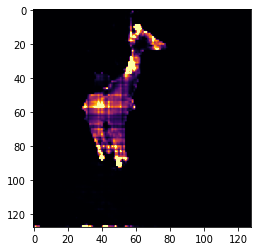

In [47]:
import matplotlib.cm as cm

size = [128,128]
h,w = 20,40
node = h*size[0] + w

aff_node = rowmax_norm(affinities)[:,node].view(1, *size)
print(aff_node.amin(), aff_node.amax())
plt.imshow(aff_node[0].detach().cpu().numpy(), cmap='inferno', vmax=0.05)
plt.show()

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


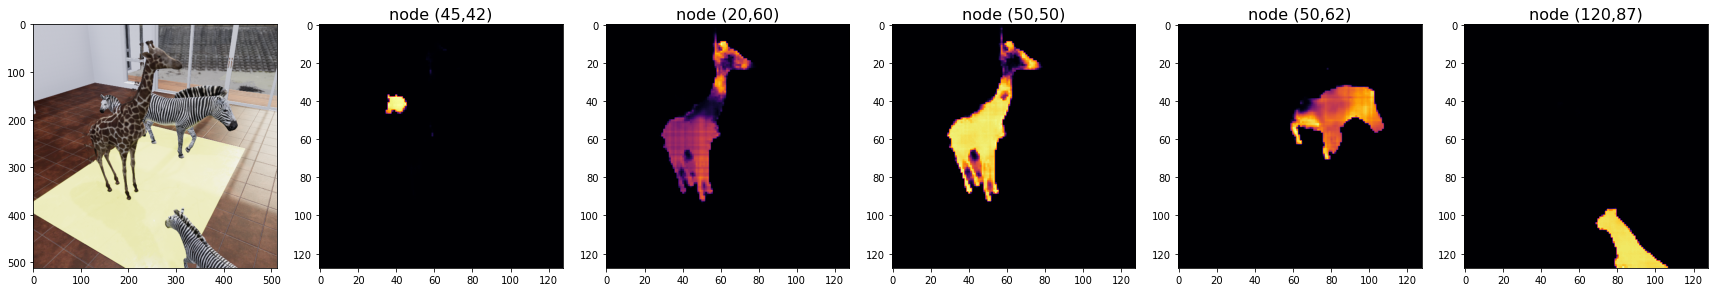

In [67]:
def plot_affinities_from_nodes(data, nodes_list=[[20,40]], cmap='inferno', vmax=0.05, z_score=5, 
                               size=[128,128]):
    N = len(nodes_list)
    fig, axes = plt.subplots(1,N+1,figsize=(4+N*4,4))
    img = data['image'].permute(1,2,0).detach().cpu().numpy()
    axes[0].imshow(img)
    full_size = img.shape[:2]
    H,W = full_size
    s = [H // size[0], W // size[1]]
    affs = data['affinities'].cuda()
    
    for i,n in enumerate(nodes_list):
        h,w = n
        h,w = (h // s[0], w // s[1])
        node = h*size[0]+w
        affs_node = rowmax_norm(affs)[:,node].view(*size)
        if vmax is None:
            _vmax = affs_node[affs_node > 0].mean() * z_score
        else:
            _vmax = vmax
        axes[i+1].imshow(affs_node.detach().cpu().numpy(), cmap=cmap, vmax=_vmax)
        axes[i+1].set_title("node (%d,%d)" % (h,w), fontsize=16)
    plt.tight_layout()
    plt.show()
    
plot_affinities_from_nodes(data, [[180,170],[80,240],[200,200],[200,250],[480,350]], vmax=1., z_score=30)